# Can personality traits and demographics predict drug use? Using supervised learning to classify drug consuption behavior

### By Micaela McCall


One of the first things that fascinated me about machine learning is the ability to predict the behavior of individuals. There are many uses for this capability, from predicting the liklihood of an individual to click on an add, to recommending follow-up mental health treatment based on risk of self-harm. 


## Project Goals

In this project, I explored the ability of three supervised learning algorithms to predict whether an individual has used a specific drug. I explored and visualized parameter selection for each model, as well as how metrics can help us select the best model for a problem. 

### I'll get started by making sure I'm searching for modules inside the project directory of the main repo


In [1]:
import os
import sys


# Project directory settings
def make_proj_module():
    """
    Sets the root directory of the project, 
    Tells python to check in this directory for modules
    """
    print("Verifying current working directory, which is: " + str(os.getcwd()))
    
    PROJ_ROOT_DIR = os.getcwd()

    if PROJ_ROOT_DIR.find('tech-news-cluster/tech_news_cluster') == -1:
        print('Appending project directory to the current working directory...')
        PROJ_ROOT_DIR = os.path.join(PROJ_ROOT_DIR, "tech_news_cluster")
    else:
        if PROJ_ROOT_DIR.find('tech-news-cluster/tech_news_cluster') != 44:
            print("Incorrect project directory, pls take a closer look")    

    # Tells python to check in this directory for modules
    if not PROJ_ROOT_DIR in sys.path:
        print("Telling python to check for modules in the project directory...")
        sys.path.append(os.path.abspath(PROJ_ROOT_DIR))
    else:
        print("Python is checking for modules in this directory")

    return PROJ_ROOT_DIR

PROJ_ROOT_DIR=make_proj_module()

Verifying current working directory, which is: /Users/mccallmv/Documents/python_projects/drug-consumption/drug_consumption
Appending project directory to the current working directory...
Telling python to check for modules in the project directory...


## Dataset

Human behavior is delightfully complex. This complexity is reflected in this [drug consumption dataset](http://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29), which contains demographic info as well as scores from personality inventories. 

This dataset is interesting to me because constructs from personality inventories can often seem abstract, so it's informative to explore how they relate to a concrete behavior. This dataset includes scores from the NEO personality inventory (neuroticism, extraversion, openness to experience, agreeableness, and conscientiousness), the BIS-11 (impulsivity), and ImpSS (sensation seeking). 

Last, it includes info on whether each individual had used a number of drugs. 

### The following code imports and saves the data:

In [3]:
import os
import sys
import pandas as pd
from urllib.request import urlretrieve
import warnings
warnings.filterwarnings('ignore')


DATA_PATH = os.path.join(PROJ_ROOT_DIR, "data")
DATA_DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00373/"
DATA_DOWNLOAD_URL = DATA_DOWNLOAD_ROOT + "drug_consumption.data"


def import_drug_data(data_url=DATA_DOWNLOAD_URL, data_path=DATA_PATH):
    """
    A function to save the data to the data directory
    """
    # Create a directory for data if it doesnt exist
    if not os.path.isdir(data_path):  
        os.makedirs(data_path)
    
    # Create a file for the data
    data_file = os.path.join(data_path, "drug_consumption.data")

    # Save the data 
    urlretrieve(data_url, data_file)


def load_drug_data():
    """
    A function to load the data into the environemnt
    """
    # Column headers:
    header_list=['ID','Age','Gender','Education','Country', 'Ethnicity', 'Nscore','Escore','Oscore','Ascore','Cscore','ImpulsiveScore','SS','Alcohol','Amphet','Amyl','Benzos','Caff','Cannabis','Choc','Coke','Crack','Ecstacy','Heroin','Ketamine','LegalH','LSD','Meth','Mushroom','Nicotine','Semeron','VSA']
    
    # Read in data 
    drug_df = pd.read_csv(os.path.join(DATA_PATH, "drug_consumption.data"), header=None, names=header_list)
    
    return drug_df


import_drug_data()
drug_df = load_drug_data()

Let's take a look at the imported data 

In [4]:
drug_df.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstacy,Heroin,Ketamine,LegalH,LSD,Meth,Mushroom,Nicotine,Semeron,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


To note:

1. I want to do binary classification, so I need to change the drug columns to be a binary (0 and 1).
2. Gender, Ethnicity, Education, and Country are encoded as real numbers. However, there is no ordering betwen the levels of these features, so they should be treated as discrete. 
3. The personality scores are scaled to a mean of 0 and standard deviation of 1 already, so these features don't need to be processed. 

### Below are a couple of functions to deal with (1) and (2)

In [5]:
import pandas as pd
def binarize_categorical_variable(df, column, yescat):
    """ 
    Fuction to turns a categorical variable in a DataFrame into a 0 or 1 response

    Arguments: 
    df = pandas DataFrame, 
    column = name of variable column as string
    yes = quoted *and bracketed* list of category names that you wish to turn to 1

    Returns: the original pandas df with new binarized variable"""

    # Change column to category dtype so that we can access it with .categories method
    df[column]=df[column].astype('category')
    
    # Create list of categories in column
    category_list = [] 
    
    for cat in df[column].cat.categories:
        category_list.append(cat)

    # Create dictionary with 1s for yes categories and 0 for no categories
    repl_dict = {}

    for cat in category_list:
        for yes in yescat:
            if cat == yes:
                repl_dict[cat] = 1   
        if repl_dict.get(cat) == None:
            repl_dict[cat] = 0

    # Replace original column in DataFrame
    df[column] = df[column].replace(repl_dict)

    return df

def new_categories(df, column, newcat):
    """ 
    Function to replace categories in a variables with new category names
    
    Arguments:
    df =  a pandas DataFrame
    column = name of variable column as string
    newcat = a list of strings that name the new category names
    
    Output: a pandas DataFrame with new column names"""

    # Change column to category dtype so that we can access it with .categories method
    df[column]=df[column].astype('category')

    # Create list of categories in this variable
    category_list = []

    for cat in df[column].cat.categories:
        category_list.append(cat)

    # Create a dictionary of new names for each old category name
    repl_dict = {}

    for i, cat in enumerate(category_list):
        repl_dict[cat] = newcat[i]

    df[column] = df[column].replace(repl_dict)

    return df

## Time to apply these functions and clean up the data

In [6]:
def cleanup_drug_df(df):
    """ A function to clean up the drug dataframe 
    
    Argument: Pandas DataFame
    
    Output: Cleaned up data as pandas DataFrame"""

    # Binarize the drug columns

    drug_df_clean = df

    for column in drug_df.columns[13:]:
        drug_df_clean = binarize_categorical_variable(drug_df_clean, column, yescat=['CL1','Cl2','CL3','CL4','CL5','CL6'])


    # Responses from individuals who said they had done an imaginary drug probably arent repliable,
    # so they are removed

    drug_df_clean = drug_df_clean[drug_df_clean.Semeron==0]



    new_categories_list = [
        ['18-24','25-34','35-44','45-54','55-64','65-100'],
        ['Female','Male'],
        ['Left school before age 16', 'Left school at age 16', 'Left school at age 17', 'Left school at age 18', 'Some college or university','Professional diploma/certificate', 'University degree', 'Masters degree', 'Doctorate degree'],
        ['USA','New Zealand','Other', 'Australia', 'Republic of Ireland','Canada', 'UK'],
        ['Black', 'Asian','White','Mixed Black/White','Other','Mixed White/Asian','Mixed Black/Asian']]

    columns_to_replace = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity']

    for i, column in enumerate(columns_to_replace):
        new_categories(drug_df_clean, column, new_categories_list[i])
    
    return drug_df_clean


# Cleanup drug DataFrame
drug_df_clean=cleanup_drug_df(drug_df)

In [7]:
drug_df_clean.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstacy,Heroin,Ketamine,LegalH,LSD,Meth,Mushroom,Nicotine,Semeron,VSA
0,1,35-44,Male,Professional diploma/certificate,UK,Mixed White/Asian,0.31287,-0.57545,-0.58331,-0.91699,...,0,0,0,0,0,0,0,0,0,0
1,2,25-34,Female,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,1,0,0,0,0,1,0,1,0,0
2,3,35-44,Female,Professional diploma/certificate,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,0,0,0,0,0,0,1,0,0,0
3,4,18-24,Male,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,0,0,0,0,0,0,0,0,0,0
4,5,35-44,Male,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,1,0,0,1,0,0,0,0,0,0


## Next, I need to select a target variable for classification
I want to pick one that isn't too unevenly distributed, so here I checked the response counts for each drug:

In [8]:
for column in drug_df_clean.columns[13:]:
    print(drug_df_clean[column].value_counts())

1    1779
0     101
Name: Alcohol, dtype: int64
0    1217
1     663
Name: Amphet, dtype: int64
0    1538
1     342
Name: Amyl, dtype: int64
0    1231
1     649
Name: Benzos, dtype: int64
1    1829
0      51
Name: Caff, dtype: int64
1    1201
0     679
Name: Cannabis, dtype: int64
1    1838
0      42
Name: Choc, dtype: int64
0    1306
1     574
Name: Coke, dtype: int64
0    1734
1     146
Name: Crack, dtype: int64
0    1255
1     625
Name: Ecstacy, dtype: int64
0    1694
1     186
Name: Heroin, dtype: int64
0    1631
1     249
Name: Ketamine, dtype: int64
0    1290
1     590
Name: LegalH, dtype: int64
0    1245
1     635
Name: LSD, dtype: int64
0    1522
1     358
Name: Meth, dtype: int64
0    1242
1     638
Name: Mushroom, dtype: int64
1    1249
0     631
Name: Nicotine, dtype: int64
0    1880
Name: Semeron, dtype: int64
0    1588
1     292
Name: VSA, dtype: int64


## From here I decided to move forward with predicting Cannabis use
Below, I created a new dataframe for machine learning with Cannabis included as the only drug. 

## Dealing with age
Also, I created two new columns 'Upper_Age' and 'Lower_Age', which replace the Age column. Right now, the age column is an ordinal feature; therefore, simple one-hot encoding loses some information. We can maintain more information about the feature by creating a new feature for the lower bound of the age and the upper bound the age. This strategy also maintains more information about the age than changing the feature to a simple mean.

In [9]:
def make_single_drug_df(df_full, drug):

    """
    A function to select a single drug as the target variable, process age variable, and isolate features dataset

    Arguments: 
    df_full = the full drug pandas Dataframe
    drug = the name of the drug column of interest as a string

    Returns:
    a tuple that is the single drug pandas dataframe and the features dataframe    
    """
    cols = [
        'ID','Age', 'Gender', 'Education', 'Country', 
        'Ethnicity', 'Nscore', 'Escore', 'Oscore', 
        'Ascore', 'Cscore', 'ImpulsiveScore','SS', drug]

    df = df_full.loc[:,cols]

    # create a new feature for the lower bound of the age and the upper bound the age.
    df['Lower_Age'], df['Upper_Age'] = zip(*df['Age'].map(lambda x: x.split('-')))

    # Convert lower and upper age to floats
    df.Lower_Age=df.Lower_Age.astype('float')
    df.Upper_Age=df.Upper_Age.astype('float')

    # Make dataframe of features
    features=df.drop(['ID','Age', drug], axis = 1)

    returns = (df, features)

    return returns

drug = 'Cannabis'
df, features = make_single_drug_df(df_full=drug_df_clean, drug= drug)   

## Now, let's explore this dataset

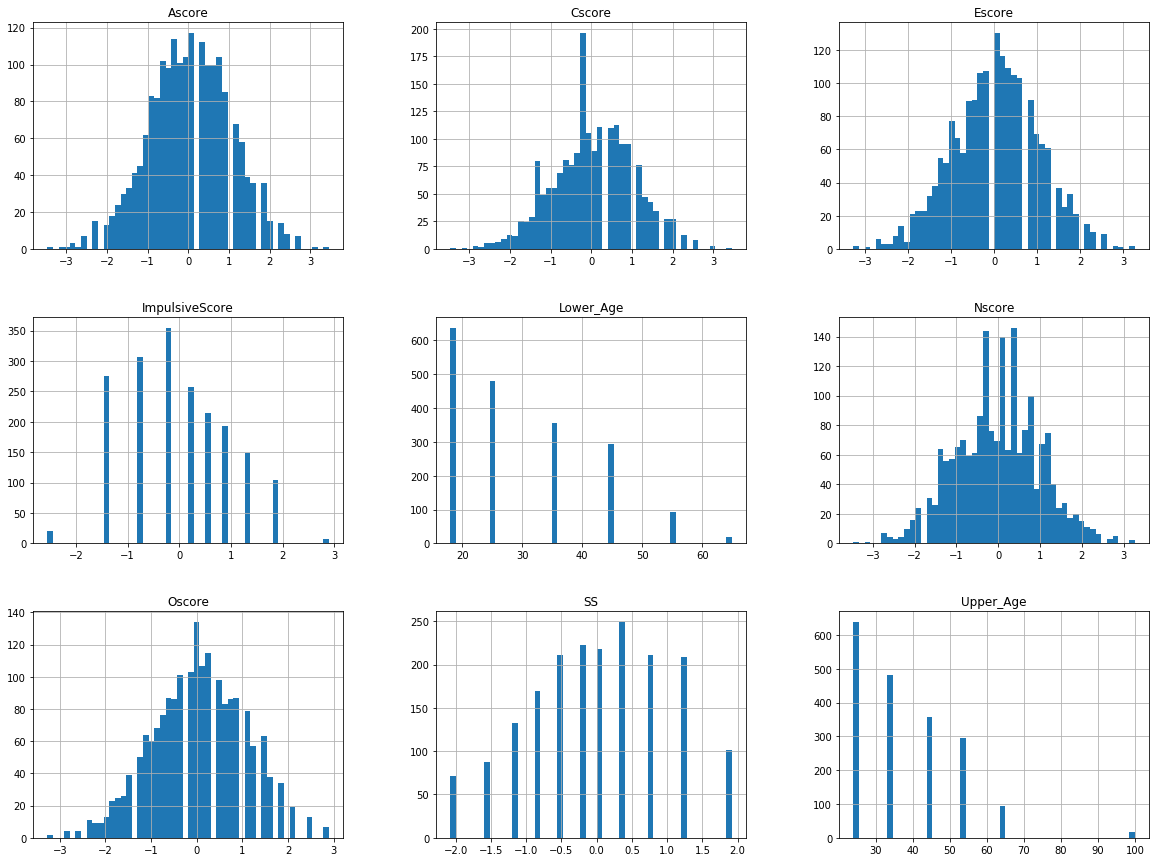

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Look at the distribution of the numerical variables
df.drop(columns=['ID', drug]).hist(bins=50, figsize=(20,15));

### - They are largely normally distributed

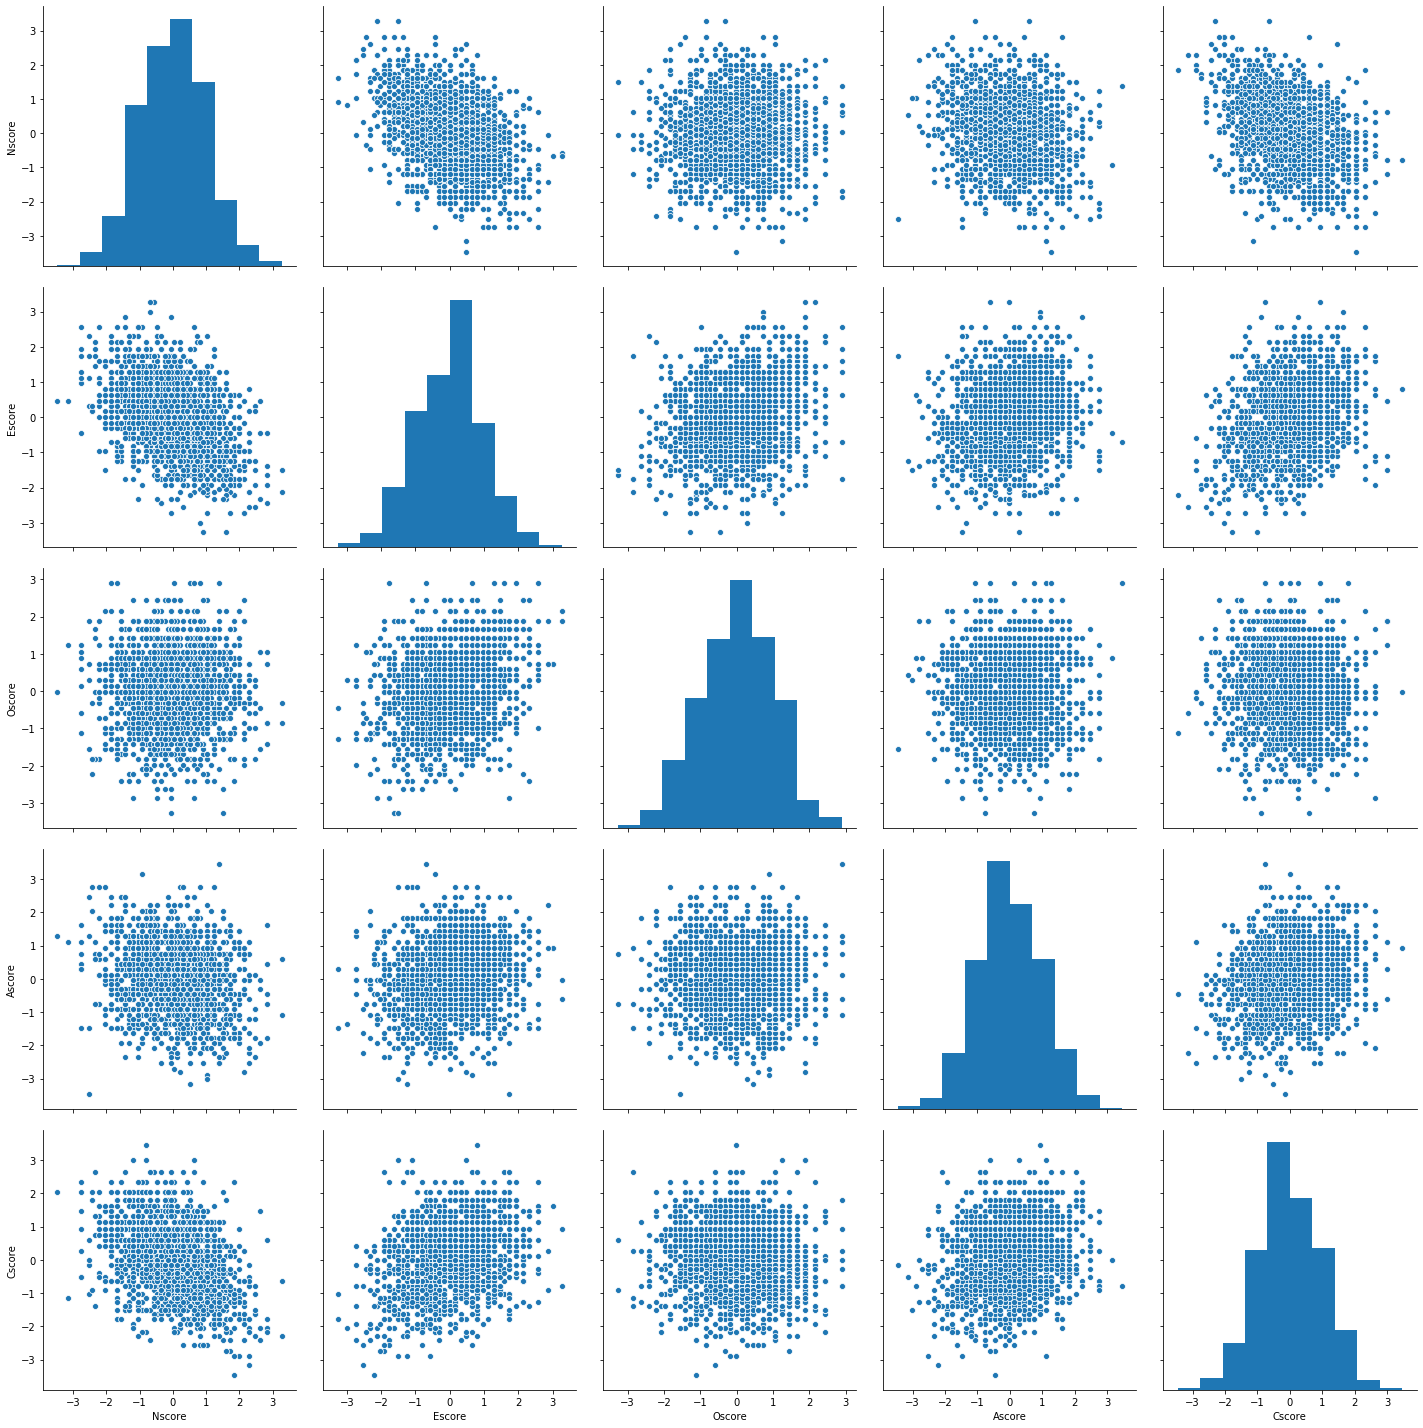

In [11]:
# Pairplot of numerical features
sns.pairplot(df, height = 4, vars=[
    'Nscore', 'Escore', 'Oscore', 
    'Ascore', 'Cscore'], );

### -Some appear to be slightly correlated, but none appear to be representing the same construct

In [12]:
# Value counts of categorical variables
col_list = ['Age', 'Gender', 'Education', 'Country', 'Education', 'Ethnicity']
for feature in col_list:
    print("Counts per response:\n", {
            n: v for n, v in zip(df.loc[:,feature].value_counts().index, df.loc[:, feature].value_counts())
        })

Counts per response:
 {'18-24': 638, '25-34': 481, '35-44': 356, '45-54': 294, '55-64': 93, '65-100': 18}
Counts per response:
 {'Female': 940, 'Male': 940}
Counts per response:
 {'Some college or university': 503, 'University degree': 480, 'Masters degree': 283, 'Professional diploma/certificate': 270, 'Left school at age 18': 99, 'Left school at age 16': 99, 'Doctorate degree': 89, 'Left school at age 17': 29, 'Left school before age 16': 28}
Counts per response:
 {'UK': 1044, 'USA': 553, 'Other': 118, 'Canada': 87, 'Australia': 53, 'Republic of Ireland': 20, 'New Zealand': 5}
Counts per response:
 {'Some college or university': 503, 'University degree': 480, 'Masters degree': 283, 'Professional diploma/certificate': 270, 'Left school at age 18': 99, 'Left school at age 16': 99, 'Doctorate degree': 89, 'Left school at age 17': 29, 'Left school before age 16': 28}
Counts per response:
 {'White': 1718, 'Other': 62, 'Black': 33, 'Asian': 25, 'Mixed White/Asian': 20, 'Mixed Black/White':

In [13]:
print("Shape of", drug, "data:", df.shape)

print("Counts per response:\n", {
    n: v for n, v in zip(df[drug].value_counts().index, df[drug].value_counts())
}, "\nProportion each response:\n", {
    n: v for n, v in zip(df[drug].value_counts().index, df[drug].value_counts() / len(df))
})

Shape of Cannabis data: (1880, 16)
Counts per response:
 {1: 1201, 0: 679} 
Proportion each response:
 {1: 0.6388297872340426, 0: 0.36117021276595745}


**Because 64% of responses are in class 1, there would be a baseline accuracy of 0.64 if we predicted all responses to be class 1**

# Time to get ready for machine learning

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, df[drug], random_state= 42)

Now, for any model we are fitting, there is preprocessing to be done and a number of hyperparameters that need to be adjusted. 

For preprocessing, we need to one-hot encode the Gender, Ethnicity, Education, and Country features. For some models, we would also need to scale the numerical features Upper_Age and Lower_Age. 

For hyperparameters, it's best to test a number of values to determine the best fit.

Both preprocessing and hyperparameter adjustment can be included in a GridSearch object from sklearn.


### By what metric should we select hyperparameters?

Because this this data is slightly imbalanced, ROC-AUC may be a better evaluation metric than accuracy (as noted, baseline accuracy would be 0.64).  

Area under the ROC curve shows the probability that a value of the positive class will have a higher score than one of the negative class according to the decision function of the model. 

The below function is a wrapper for a GridSearchCV object that searches for the best parameters for a classifier, reports a number of metrics for the classifier, and refits on a metric of choice. It also produces a heatmap for cross validation results so we can visualize if we are searching the best hyperparameter space.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score,precision_score, roc_auc_score, accuracy_score


# Wrapper to fit GridSearchCV optimized with different scores:
def grid_search_wrapper(X_train, y_train, pipe, param_grid, refit_score):
    """
    Fits a GridSearchCV classifier that optimizes with refit_score and reports ROC AUC, precision score, and accuracy
    
    Arguments: 
    X_train = training features
    y_train training target
    pipe = a pipline object that include preprocessing steps and chosen classifier
    param_grid = a dict or list of dicts with keys as strings of the 
    parameter names and values are a list of possible values for the parameter
    refit_score = string naming the score to refit by

    Returns: tuple of GridSearchCV (for using for predictions) and results pandas DataFrame for evaluating the model
    """
    # Scores to report in the results
    scorers = {
        'roc_auc' : make_scorer(roc_auc_score),
        'precision_score' : make_scorer(precision_score),
        'accuracy' : make_scorer(accuracy_score)
    }

    # Create a GridSearchCV instance optimized for refit_score 
    grid_search = GridSearchCV(pipe, param_grid, scoring=scorers, refit=refit_score, cv=5, return_train_score=True, n_jobs=-1)

    # Fit on training data
    grid_search.fit(X_train,y_train)

    # Store results of each cross val
    results = pd.DataFrame(grid_search.cv_results_)

    # Make a list of the parameters to extract from results
    subset_results=['mean_test_precision_score', 'mean_test_roc_auc', 'mean_test_accuracy']
    
    # Initialize list of params and list of parameter dimensions for graphing
    params = []
    dim = []

    # SVC has a 'list' type parameter grid (two kernels)
    # this extracts the best kernel if the classifier used is SVC
    # SVC must be named 'svc' for this to work
    if 'svc__kernel' in grid_search.best_params_:
        best_kernel = grid_search.best_params_['svc__kernel']
    
    # add params to subset_results. If the classifier is SVC, only add the params for the best kernel
    if type(param_grid) == list:
        for grid in param_grid:
            if grid['svc__kernel']==[best_kernel]:
                for param in grid.keys():
                    # Save length of the param for the dimensions of the graph
                    dim.append(len(grid[param]))

                    # Save param for graphing later
                    if param not in params:
                        params.append(param)
                # take out dimension of kernel 
                dim = dim[1:]
            else:
                for param in grid.keys():
                    # Save param for graphing later
                    if param not in params:
                        params.append(param)
        # Take out kernel param
        params=params[1:]
        # Add the param to the list of column names in results
        for param in params:
            param_str='param_'+str(param)
        if param_str not in subset_results:
            subset_results.append(param_str)
        # Selected results
        results= results[results.param_svc__kernel==best_kernel].loc[:,subset_results].round(3).reindex()  
    else:
        for param in param_grid.keys():
            # Save param for graphing later
            params.append(param)
            # Save dimensions of param for graphing
            dim.append(len(param_grid[param]))
            param_str='param_'+str(param)
            if param_str not in subset_results:
                    subset_results.append(param_str)
        # Selected results
        results = results.loc[:,subset_results].round(3).reindex()  

    #Print best params for the chosen score and the best cross-val score
    print(
        "Parmaeters when refit for {}".format(refit_score), 
        "\n {}".format(grid_search.best_params_), 
        "\nBest cross-val roc_auc score: {}".format(np.max(results.mean_test_roc_auc)),
        "\nBest cross-val accuracy score: {:.2f}".format(np.max(results.mean_test_accuracy)))
    
    # Store the name of the score to plot on a heat map
    plot_score = 'mean_test_' + str(refit_score)

    # Store average cross-val score of each combo of parameters in an array the size of the parameter grid space
    scores = np.array(results[plot_score]).reshape(dim[0],dim[1])

    # Plot the score of each combo of parameters on a heatmap
    plt.figure(figsize=(10,6))
    heatmap=sns.heatmap(scores, annot=True)
    plt.title('Cross-val test scores for ' + str(refit_score))
    plt.xlabel(params[1])
    plt.ylabel(params[0])
    plt.xticks(np.arange(dim[1]), results[subset_results[-1]].unique())
    plt.yticks(np.arange(dim[0]), results[subset_results[-2]].unique())
    plt.show()

    # Return both the grid search object and the results DataFrame
    returns = (grid_search, results)

    return returns

## Time to train the models and select the best hyperparameters for each one
Now, we can apply this function to several supervised learning algorithms in order to visualize the parameter space and modify searches. 

### We'll start with Logistic regression

parameter grid:
{'logreg__C': [0.001, 0.01, 1, 100], 'logreg__penalty': ['l1', 'l2']}
Parmaeters when refit for roc_auc 
 {'logreg__C': 0.01, 'logreg__penalty': 'l2'} 
Best cross-val roc_auc score: 0.733 
Best cross-val accuracy score: 0.77


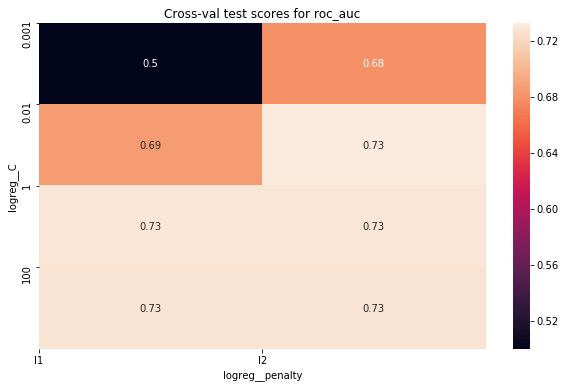

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import numpy as np

# First, we make a column transformer to scale the numerical features, and one-hot encode the categorical ones
ct = ColumnTransformer([
    ("num", StandardScaler(), ['Upper_Age', 'Lower_Age']), 
     ("cat", OneHotEncoder(handle_unknown = 'ignore', sparse=False), ['Gender', 'Education', 'Country', 'Ethnicity'])], 
     remainder='passthrough')

# Next, make a pipeline with the column transformer and the logistic regression instance
pipe = Pipeline([
    ("preparation", ct),
    ("logreg", LogisticRegression(solver='liblinear'))
])

# Now, we make a parameter grid for the grid search to search over
# l1 and l2 are types of regularization; they restrict the model and prevent it from overfitting by restricting the coefficients to be near zero. 
# l1 also forces some to be exactly 0 so that they can be ignorned entirely
# C specifies the strength of the regularization
param_grid = {
    'logreg__C': [0.001, 0.01, 1, 100],
    'logreg__penalty': ["l1", "l2"]
}

print("parameter grid:\n{}".format(param_grid))

# Run the grid search, refitting with the ROC AUC metric
grid_search, logreg_results = grid_search_wrapper(X_train, y_train, pipe=pipe, param_grid=param_grid, refit_score='roc_auc')

# Assign the full pipeline for the estimator selected by the grid search to it's own object
logreg_pipe = grid_search.best_estimator_  

An ROC-AUC score of 0.73 is ok, but not awesome. It's definitely worth seeing if another model would produce better results.

### Next, we'll look at SVC (support vector classifier)

Parmaeters when refit for roc_auc 
 {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'} 
Best cross-val roc_auc score: 0.753 
Best cross-val accuracy score: 0.77


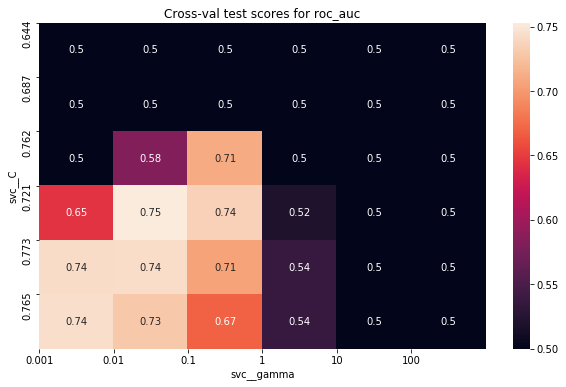

In [24]:
from sklearn.svm import SVC

# We can use the same ColumnTransformer instance as was used for Logistic regression
# We add the SVC to the pipeline

pipe = Pipeline([
    ("preparation", ct),
    ("svc", SVC())
])

# This parameter grid is a list of dicts instead of a dict
# The rbf kernel is unsed to project the data into a higher dimensional freature space without actuall computing the transformation
# Linear kernel keeps the features in linear space
# C is a regularization parameter, corresponding to the importance that all training samples are
# classified correctly, sacrificing the smoothness of margin of the decision function
# gamma defines how much influence a single training sample will have on the decision function, ie
# the inverse of the radius of the influence of support vectors
param_grid = [
    {'svc__kernel': ['rbf'], 'svc__C': [0.001, 0.01, 0.1, 1, 10, 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, 
    {'svc__kernel': ['linear'], 'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

# Run the grid search
grid_search, svc_results = grid_search_wrapper(X_train, y_train, pipe, param_grid, refit_score='roc_auc')


Because the largest scores are near the endge of the heat map, we'll adjust the parameter grid to see if better scores are beyong the search space of the last grid search

Parmaeters when refit for roc_auc 
 {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'} 
Best cross-val roc_auc score: 0.753 
Best cross-val accuracy score: 0.77


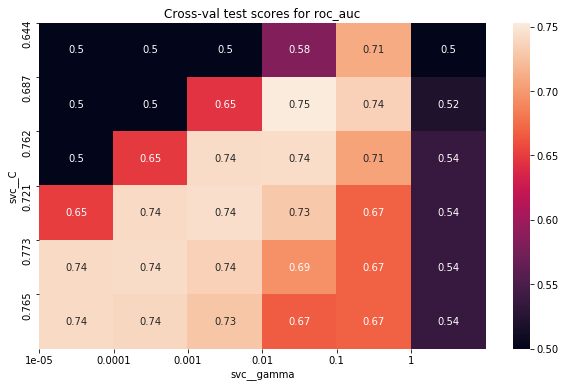

In [25]:
param_grid = [
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100, 1000, 10000], 'svc__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}, 
    {'svc__kernel': ['linear'], 'svc__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search, svc_results = grid_search_wrapper(X_train, y_train, pipe, param_grid, refit_score='roc_auc')

svc_pipe = grid_search.best_estimator_

This seems like a better parameter grid space because the plot is filled up with evenly with the higher cross-val scores.

But, the best parameters are the same as the ones we found in the first grid search. 

The best ROC AUC from cross validation is slightly higher! But still not awesome.

### Last, we'll try a Random Forest classifier
RF is the average of a number of decision tree classifiers with some randomness injected into the tree-building process.

Parmaeters when refit for roc_auc 
 {'rf__max_depth': 35, 'rf__max_features': 7} 
Best cross-val roc_auc score: 0.742 
Best cross-val accuracy score: 0.77


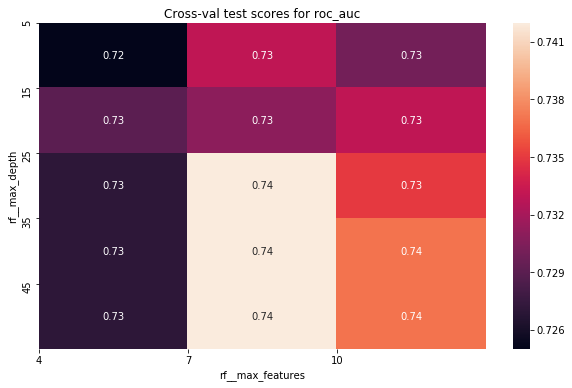

In [19]:
from sklearn.ensemble import RandomForestClassifier

# For RF, we don't need to scale the numerical features, so we'll use a different column transformer
ct = ColumnTransformer([
     ("cat", OneHotEncoder(handle_unknown = 'ignore', sparse=False), ['Gender', 'Education', 'Country', 'Ethnicity'])], 
     remainder='passthrough')

pipe = Pipeline([
    ("preparation", ct),
    ("rf", RandomForestClassifier(n_estimators=200, random_state=2))
])

# The parameters that will be searched accross are max_depth, and max_features
# max_depth limits the number of decisions that can happen in a tree; set lower to avoid overfitting
# max_features is the number of features randomly selected to fit each tree; set lower to include more randomness and avoid overfitting
#   usually set to sqrt(n_features)

param_grid = {
    'rf__max_depth': [5, 15, 25, 35, 45],
    'rf__max_features': [4, 7, 10]
}

grid_search, rf_results = grid_search_wrapper(X_train, y_train, pipe=pipe, param_grid=param_grid, refit_score='roc_auc')
rf_pipe = grid_search.best_estimator_

The best ROC AUC score for cross validation isn't better than SVC. 
## Therefore, it looks like SVC is the best model. 
___
## Another way to determine the best model 
Alternatively, we can use a grid search between the models and parameters together. This is demonstrated below:

In [22]:
ct = ColumnTransformer([
    ("num", StandardScaler(), ['Upper_Age', 'Lower_Age']), 
     ("cat", OneHotEncoder(handle_unknown = 'ignore', sparse=False), ['Gender', 'Education', 'Country', 'Ethnicity'])], 
     remainder='passthrough')

# Initialize pipe with column transformer and Log Reg
pipe = Pipeline([
    ("preparation", ct),
    ("classifier", LogisticRegression())
])

# Param grid with all possibilities for all models
param_grid = [
    {'classifier': [LogisticRegression(solver='liblinear')], 
    'classifier__C': [0.001, 0.01, 1, 100],
    'classifier__penalty': ["l1", "l2"]},
    {'classifier': [LogisticRegression(solver='lbfgs', penalty="l2", max_iter=500)], 
    'classifier__C': [0.001, 0.01, 1, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=200, random_state=2)],
    'classifier__max_depth': [15, 25, 35],
    'classifier__max_features': [4, 7, 10]},
    {'classifier': [SVC()],
    'classifier__C': [0.1, 1, 10, 100, 1000, 10000], 
    'classifier__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]}
]


# For this grid search between all classifiers, I decided to refit on ROC AUC

clf_grid = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(roc_auc_score))
clf_grid.fit(X_train, y_train)

print("Best classifier and params: \n{}\n".format(clf_grid.best_params_))
print("Best cross-val score: {:.2f}".format(clf_grid.best_score_))

Best classifier and params: 
{'classifier': SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 1, 'classifier__gamma': 0.01}

Best cross-val score: 0.75


### This grid search also came up with the same conclusion: SVC is the best estimator, with the above params

## We are ready to generate predictions!
Now, we can generate predictions on the test set using the SVC model and inspect the metrics on the test set.

In [26]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

print("Test set roc-auc for SVC: {:.2f}".format(roc_auc_score(y_test, clf_grid.decision_function(X_test))))
print("Test set accuracy score for SVC: {:.2f}".format(accuracy_score(y_test, clf_grid.predict(X_test))))
print("\nMetrics for SVC: \n", classification_report(y_test, svc_pipe.predict(X_test)))

Test set roc-auc for SVC: 0.81
Test set accuracy score for SVC: 0.76

Metrics for SVC: 
               precision    recall  f1-score   support

           0       0.68      0.68      0.68       177
           1       0.81      0.81      0.81       293

    accuracy                           0.76       470
   macro avg       0.74      0.74      0.74       470
weighted avg       0.76      0.76      0.76       470



Test set roc-auc for SVC: 0.81
Test set accuracy score for SVC: 0.76


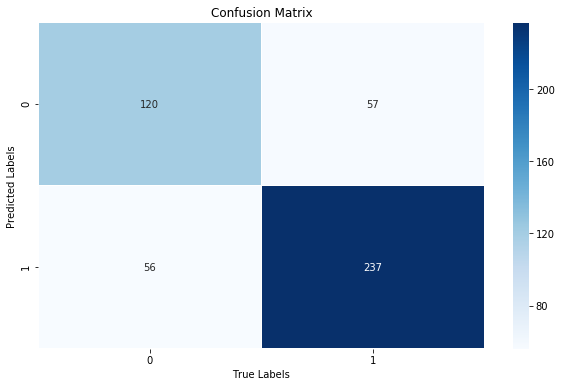

In [32]:
print("Test set roc-auc for SVC: {:.2f}".format(roc_auc_score(y_test, clf_grid.decision_function(X_test))))
print("Test set accuracy score for SVC: {:.2f}".format(accuracy_score(y_test, clf_grid.predict(X_test))))
cm=confusion_matrix(y_test, clf_grid.predict(X_test))
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, linewidth=0.5, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels');

One aspect of looking at these evaluation metrics is that the model uses the default thresholds for the decision function, which is 0 (positive values are classified in the positive class). 

The model with the best ROC AUC may still not perform well if the threshold is in a suboptimal place. 

Because this model is still not getting an impressively high performance, I will take a look at the ROC curve to see if the threshold of the decision function is in the optimal place (i.e. high TPR and high FPR) 

## Below, we plot the false positive rate by the true positive rate for every threshold value in the decision curve

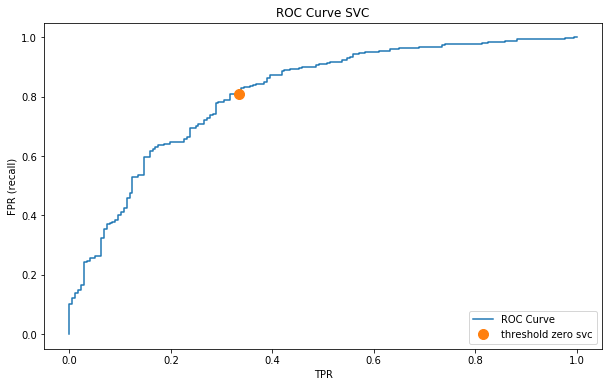

In [46]:
from sklearn.metrics import roc_curve

# Extract false positive rate and true positive rate
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, svc_pipe.decision_function(X_test))

# Extract the threshold by getting the value in the decision function that is closest to 0 (default is 0)
thresh_svc = np.argmin(np.abs(thresholds_svc))

def plot_roc():
    # Plot FPR and TPR
    plt.figure(figsize=(10,6))
    plt.plot(fpr_svc, tpr_svc, label="ROC Curve")
    plt.ylabel('FPR (recall)')
    plt.xlabel('TPR')

    # Plot threshold
    plt.plot(fpr_svc[thresh_svc], tpr_svc[thresh_svc], 'o', markersize = 10, label = "threshold zero svc")
    plt.legend(loc=4)
    plt.title("ROC Curve SVC")
    plt.show()

plot_roc()

## Looks like the default threshold for the decision function is in a pretty good spot, so this is probably the optimal model

Although the SVC was the highest performing model, I wanted to extract feature importances from the Random Forest model in order to get an idea of which features were most predictive in that context.

## Below, we visualize the feature importances from the Random Forest model

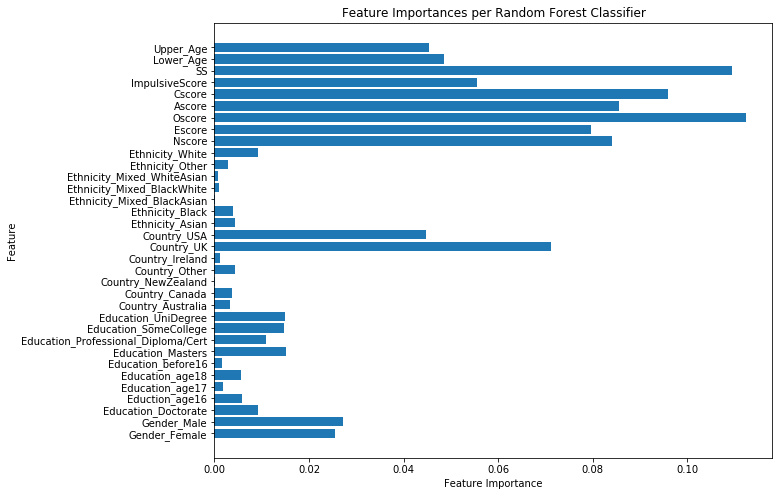

In [43]:
# Isolate the rf model from the pipeline 
rf = rf_pipe.named_steps['rf']

# These are the column names from the numpy array producted from the column transformer
ct_index = [
    'Gender_Female', 'Gender_Male', 'Education_Doctorate', 
    'Eduction_age16', 'Education_age17', 'Education_age18', 
    'Education_before16', 'Education_Masters', 'Education_Professional_Diploma/Cert', 
    'Education_SomeCollege', 'Education_UniDegree', 'Country_Australia', 
    'Country_Canada', 'Country_NewZealand', 'Country_Other', 'Country_Ireland', 
    'Country_UK', 'Country_USA', 'Ethnicity_Asian', 'Ethnicity_Black', 'Ethnicity_Mixed_BlackAsian',
    'Ethnicity_Mixed_BlackWhite', 'Ethnicity_Mixed_WhiteAsian', 'Ethnicity_Other', 
    'Ethnicity_White', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'ImpulsiveScore', 'SS',
    'Lower_Age', 'Upper_Age']

# Create a data frame of feature importances for each feature in the transformed dataset
feature_importances = pd.DataFrame(rf.feature_importances_, index=ct_index, columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importnaces 
def plot_rf_feature_importance():
    """
    A function to plot feature importances as a horizontal barplot
    """
    plt.figure(figsize=(10,8))
    n_features = len(ct_index)
    plt.barh(np.arange(n_features), rf.feature_importances_, align='center')
    plt.yticks(np.arange(len(ct_index)), ct_index, size= 10)
    plt.ylabel("Feature")
    plt.xlabel("Feature Importance")
    plt.title("Feature Importances per Random Forest Classifier")
    plt.show()

plot_rf_feature_importance()

It's interesting that all of the most important features are the personality measures and not the demographic measures. I think it's interesting that this connects these abstract measures to a concrete behavior.

In [112]:
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


scores = [['Nscore', 'Neuroticism score'],
              ['Escore', 'Extraversion score'],
              ['Oscore', 'Openness to experience score'],
              ['Ascore','Agreeableness score'],
              ['Cscore','Conscientiousness score'],
              ['ImpulsiveScore', 'Impulsivity score'],
              ['SS', 'Sensation seeking score']]

colors = ['#13eac9', '#0504aa']


for score in scores:
    df_long = df[['ID', 'Cannabis', score[0]]].pivot(columns='Cannabis', values=score[0])
    df_long = df_long[[0,1]].rename(columns={0:'Never used Cannabis', 1:'Used Cannabis'})
    fig = ff.create_distplot([df_long[c].dropna() for c in df_long.columns], 
                             df_long.columns.astype('str'), 
                             bin_size=.2,
                             show_rug=False,
                             colors=colors)   
    fig.update_layout(template="plotly_white", width=800, height =350)
    fig.update_traces(marker={"opacity": 0})
    fig.update_xaxes(title_text = score[1])
    fig.update_yaxes(title_text = 'Frequency')

    fig.show()


In [145]:
import plotly.graph_objects as go

df.Age = df.Age.astype('category', ordered=True)



fig = go.Figure()

fig.add_trace(go.Violin(x=df.Cannabis[ df.Cannabis == 1 ],
                        y=df.Age.astype('category', ordered=True)[ df.Cannabis == 1 ],
                        legendgroup='Yes', scalegroup='Yes', name='Yes',
                        side='positive',
                        line_color='blue')
             )
fig.add_trace(go.Violin(x=df.Cannabis[ df.Cannabis == 1 ],
                        y=df.Age.astype('category', ordered=True)[ df.Cannabis == 0 ],
                        legendgroup='No', scalegroup='No', name='No',
                        side='negative',
                        line_color='purple')
             )
fig.update_traces(meanline_visible=True)
fig.update_layout(violinmode='overlay')
fig.show()

In [146]:
df.Age.dtype

CategoricalDtype(categories=['18-24', '25-34', '35-44', '45-54', '55-64', '65-100'], ordered=True)